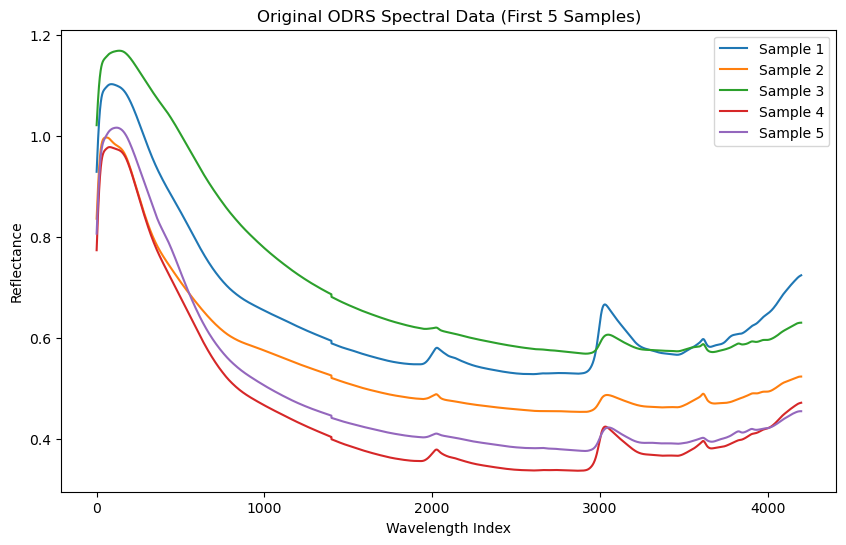

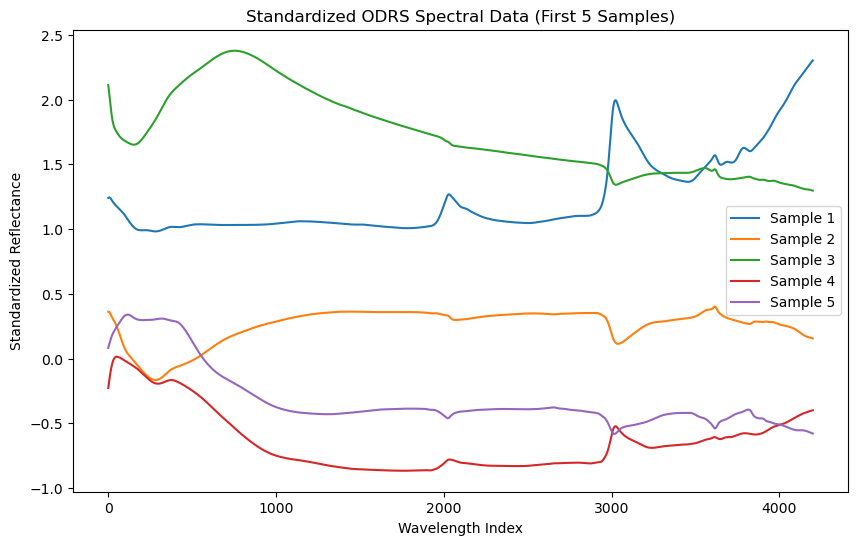

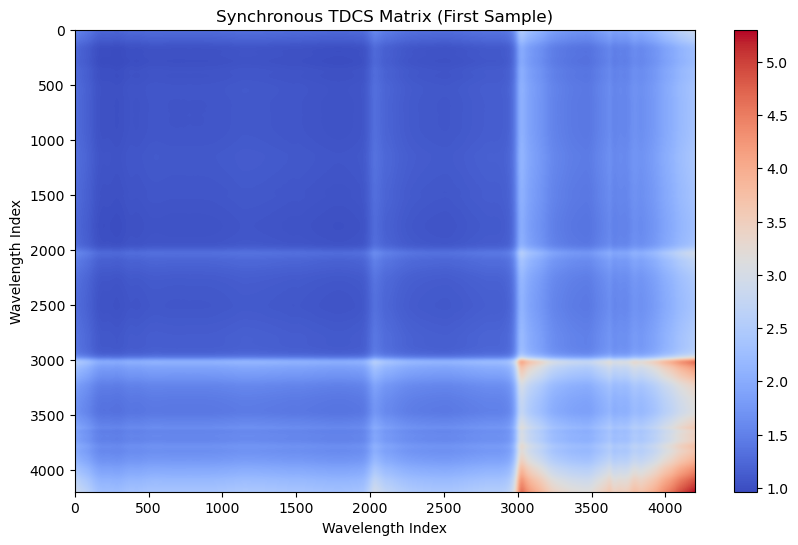

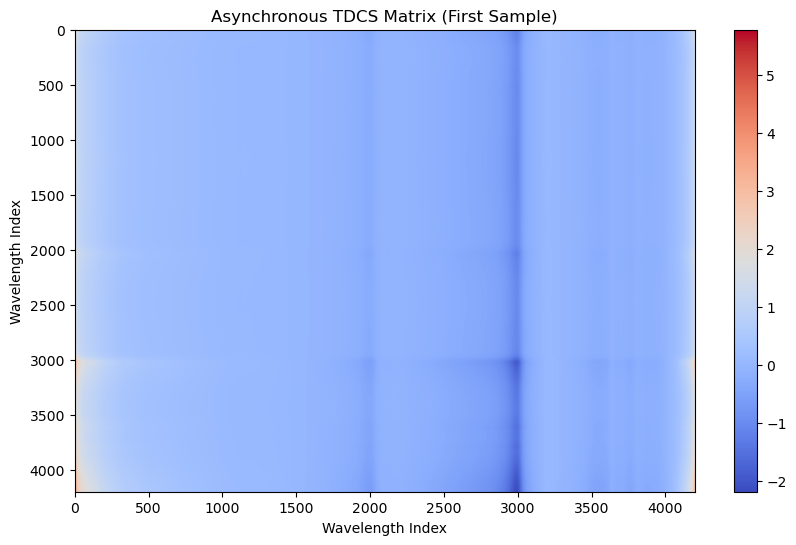

Epoch 1/100
17/17 [==============================] - 4s 175ms/step - loss: 5246.7075 - mae: 40.4580 - val_loss: 4346.7856 - val_mae: 36.4512
Epoch 2/100
17/17 [==============================] - 2s 145ms/step - loss: 3292.6826 - mae: 30.1397 - val_loss: 3721.0713 - val_mae: 38.6336
Epoch 3/100
17/17 [==============================] - 3s 151ms/step - loss: 3306.8052 - mae: 30.9723 - val_loss: 3186.8271 - val_mae: 34.1263
Epoch 4/100
17/17 [==============================] - 3s 154ms/step - loss: 2699.6008 - mae: 29.0489 - val_loss: 3002.1743 - val_mae: 28.2156
Epoch 5/100
17/17 [==============================] - 3s 155ms/step - loss: 2289.5505 - mae: 27.2710 - val_loss: 2383.3076 - val_mae: 27.4582
Epoch 6/100
17/17 [==============================] - 3s 155ms/step - loss: 1957.7413 - mae: 24.9564 - val_loss: 2309.2795 - val_mae: 27.6016
Epoch 7/100
17/17 [==============================] - 3s 158ms/step - loss: 1821.2286 - mae: 24.4423 - val_loss: 2305.2969 - val_mae: 27.8067
Epoch 8/100
1

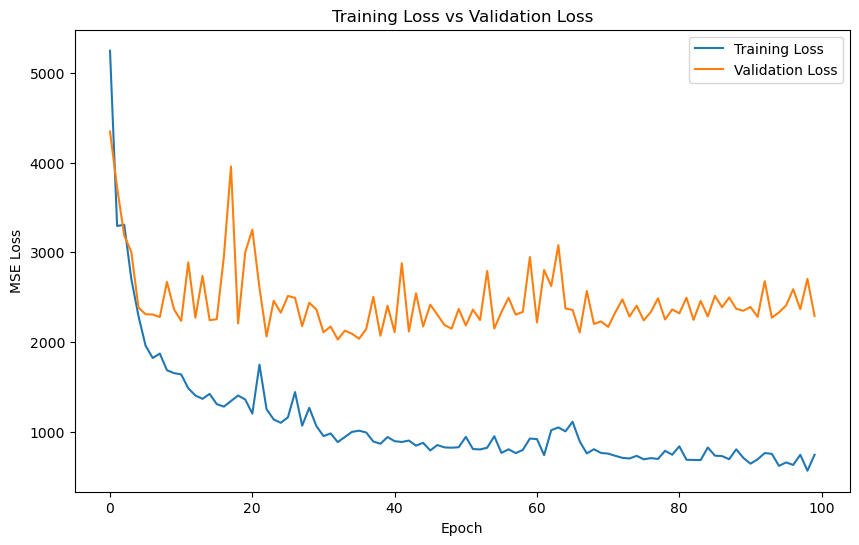

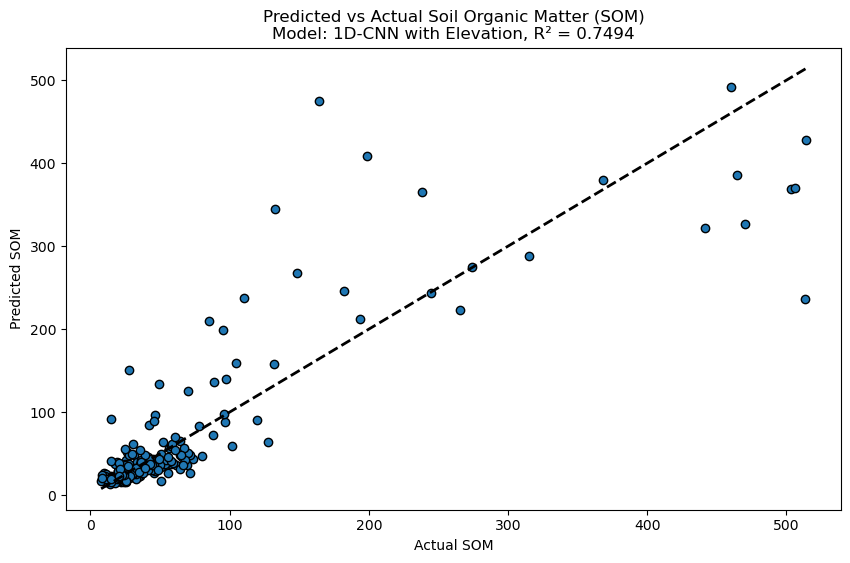

Model evaluation - Mean Squared Error (MSE): 2288.8387668626337, R² score: 0.7493615783767524


In [1]:
import numpy as np
import pandas as pd
from scipy.signal import hilbert
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models

# Step 1: Load spectral data (ODRS)
data = pd.read_csv(r'C:\Users\Hai\Desktop\mergedUK_OCdata.csv')  # Update with the correct path
X = data.iloc[:, :-1].values  # Spectral data (ODRS)
y = data.iloc[:, -1].values   # Soil Organic Matter (SOM)

# Step 1.1: Load elevation data and merge with spectral data
elevation_data = pd.read_csv(r'C:\Users\Hai\Desktop\elevation.csv')  # Load elevation data
elevation = elevation_data.iloc[:, -1].values  # Extract the last column for elevation
elevation = elevation.reshape(-1, 1)  # Reshape for concatenation

# Plot the original spectral data for the first few samples
plt.figure(figsize=(10, 6))
for i in range(5):
    plt.plot(X[i], label=f'Sample {i+1}')
plt.title('Original ODRS Spectral Data (First 5 Samples)')
plt.xlabel('Wavelength Index')
plt.ylabel('Reflectance')
plt.legend()
plt.show()

# Step 2: Standardize the spectral data (1D)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Plot the standardized spectral data for the first few samples
plt.figure(figsize=(10, 6))
for i in range(5):
    plt.plot(X_scaled[i], label=f'Sample {i+1}')
plt.title('Standardized ODRS Spectral Data (First 5 Samples)')
plt.xlabel('Wavelength Index')
plt.ylabel('Standardized Reflectance')
plt.legend()
plt.show()

# Step 3: Generate TDCS matrices for each sample individually
def generate_sample_tdcs(X_sample):
    # Function to generate synchronous TDCS
    synchronous_matrix = np.dot(X_sample.T, X_sample) / (X_sample.shape[0] - 1)
    
    # Function to generate asynchronous TDCS
    analytic_signal = hilbert(X_sample)  # Hilbert transform
    asynchronous_matrix = np.imag(np.dot(analytic_signal.T, analytic_signal)) / (X_sample.shape[0] - 1)
    
    # Combine synchronous and asynchronous matrices
    combined_tdcs = np.concatenate((synchronous_matrix.flatten(), asynchronous_matrix.flatten()))
    
    return combined_tdcs

# Apply TDCS generation to each sample
X_tdcs = np.array([generate_sample_tdcs(sample.reshape(-1, 1)) for sample in X_scaled])

# Plot a synchronous and asynchronous TDCS matrix for the first sample
synchronous_matrix = np.dot(X_scaled[0].reshape(-1, 1), X_scaled[0].reshape(1, -1))
asynchronous_matrix = np.imag(np.dot(hilbert(X_scaled[0].reshape(-1, 1)), hilbert(X_scaled[0].reshape(1, -1))))

plt.figure(figsize=(10, 6))
plt.imshow(synchronous_matrix, cmap='coolwarm', aspect='auto')
plt.colorbar()
plt.title('Synchronous TDCS Matrix (First Sample)')
plt.xlabel('Wavelength Index')
plt.ylabel('Wavelength Index')
plt.show()

plt.figure(figsize=(10, 6))
plt.imshow(asynchronous_matrix, cmap='coolwarm', aspect='auto')
plt.colorbar()
plt.title('Asynchronous TDCS Matrix (First Sample)')
plt.xlabel('Wavelength Index')
plt.ylabel('Wavelength Index')
plt.show()

# Step 4: Combine 1D, 2D TDCS data and elevation for model input
X_combined_with_elevation = np.concatenate((X_scaled, X_tdcs, elevation), axis=1)

# Step 5: Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_combined_with_elevation, y, test_size=0.3, random_state=42)

# Reshape data for 1D-CNN input (samples, timesteps, channels)
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# Step 6: Build the 1D-CNN model
def build_1d_cnn_model(input_shape):
    model = models.Sequential()

    # 1st convolutional layer with 32 filters and 3x1 kernel size
    model.add(layers.Conv1D(32, 3, activation='relu', input_shape=input_shape))
    model.add(layers.MaxPooling1D(2))  # Max pooling

    # 2nd convolutional layer
    model.add(layers.Conv1D(64, 3, activation='relu'))
    model.add(layers.MaxPooling1D(2))

    # 3rd convolutional layer
    model.add(layers.Conv1D(64, 3, activation='relu'))

    # Flatten the data to feed into Dense layers
    model.add(layers.Flatten())
    
    # Fully connected layer
    model.add(layers.Dense(64, activation='relu'))
    
    # Output layer for regression
    model.add(layers.Dense(1))

    # Compile the model
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    
    return model

# Step 7: Compile and train the model
input_shape = X_train.shape[1:]  # Get input shape
cnn_model = build_1d_cnn_model(input_shape)

# Train the model
history = cnn_model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test))

# Step 8: Evaluate model performance
y_pred = cnn_model.predict(X_test)

# Calculate MSE and R² score
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"1D-CNN Model with Combined 1D and 2D Data - MSE: {mse}, R²: {r2}")

# Step 9: Plot training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training Loss vs Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.legend()
plt.show()

# Step 10: Plot predicted vs actual SOM values, with R² value annotated
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, edgecolors=(0, 0, 0))
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.xlabel('Actual SOM')
plt.ylabel('Predicted SOM')
plt.title(f'Predicted vs Actual Soil Organic Matter (SOM)\nModel: 1D-CNN with Elevation, R² = {r2:.4f}')
plt.show()

# Step 11: Print evaluation metrics
print(f"Model evaluation - Mean Squared Error (MSE): {mse}, R² score: {r2}")
